In [105]:
import pickle
from torch_geometric.data import Data
from torch import nn
import matplotlib.pyplot as plt
import torch
import multiprocessing as mp
from tqdm import tqdm
from gnn_utils import embedd

In [106]:
with open('make-sentences.pickle', 'rb') as f:
    sentences = pickle.load(f)

In [107]:
classes = list({sentence.semlink[0].frame for sentence in sentences})

In [108]:
classes

['Building',
 'Manufacturing',
 'Causation',
 'Cause_change',
 'Intentionally_create',
 'Cooking_creation',
 'Earnings_and_losses',
 'Arriving']

In [137]:
context = mp.get_context('spawn')
data = list()
with context.Pool(6) as p:
    for val in tqdm(p.imap(embedd, sentences)):
        data.append(val)

526it [13:26,  1.53s/it]


In [138]:
len(data), data[0].shape

(526, torch.Size([16]))

In [139]:
x = torch.stack(data).float()
x = nn.functional.normalize(x, dim=1)

In [140]:
y = torch.stack([torch.tensor([int(val == sentence.semlink[0].frame) for val in classes], dtype=torch.float32) for sentence in sentences])

In [141]:
train_x = x[:450]
test_x = x[450:]
train_y = y[:450]
test_y = y[450:]

In [162]:
model = nn.Sequential(nn.Linear(16, 128),
                      nn.ReLU(),
                      nn.Linear(128, 128),
                      nn.ReLU(),
                      nn.Linear(128, 128),
                      nn.ReLU(),
                      nn.Linear(128, 8),
                      nn.Sigmoid())

In [163]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

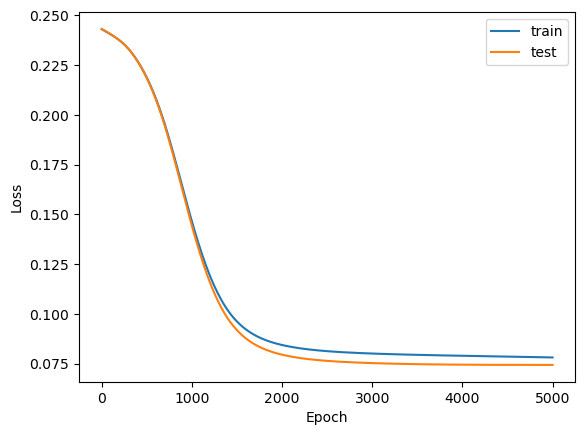

In [164]:
def train(x, y):
    pred_y = model(x)
    loss = loss_function(pred_y, y)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(x, y):
    pred_y = model(x)
    return loss_function(pred_y, y).item()

loss = list()
acc = list()
for epoch in range(5000):
    loss.append(train(train_x, train_y))
    acc.append(test(test_x, test_y))

plt.plot(loss, label='train')
plt.plot(acc, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [165]:
id_set = {sentence.id for sentence in sentences}

In [166]:
22168017 in id_set

False

In [167]:
22170032 in id_set

False

In [168]:
22172005 in id_set

False

In [169]:
from deepbank_parser import DeepbankParser

In [177]:
sentence = DeepbankParser().parse_sentence(22160014)

In [172]:
from data_classes import Sentence

In [179]:
sentence_ = Sentence(sentence.id, sentence, [])

In [181]:
from gnn_utils import node2vec, eds2data

In [182]:
x = node2vec(eds2data(sentence.eds))

In [185]:
x_ = nn.functional.normalize(x.mean(dim=0), dim=0)

In [186]:
x_

tensor([ 0.1197, -0.5051, -0.2393,  0.1444, -0.0821,  0.2916,  0.1762, -0.3309,
         0.0833,  0.3040, -0.3024, -0.0970,  0.0025,  0.4064,  0.2330,  0.0196])

In [195]:
y = model(x_)

In [197]:
y

tensor([0.0249, 0.5532, 0.2022, 0.1273, 0.0844, 0.0206, 0.0225, 0.0166],
       grad_fn=<CopySlices>)

In [198]:
classes[1]

'Manufacturing'